# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Import Plot Stylesheet

In [3]:
plt.style.use(['seaborn-v0_8-paper', Path.cwd() / 'plotstyle' / 'paper.mplstyle'])
cm = 1/2.54

#### Erzeugnung des Moduls

In [4]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [5]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [6]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# #Normalisieren der Tensoren
# x_input = norm(x_input, p=1, dim = 1)
# y_output = norm(y_output, p=1, dim = 0)

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [7]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [8]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [9]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if (pred[i,0] - y[i,0] and pred[i,1] - y[i,1]) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [10]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

Epoch 1/200, Iteration 1/12, Loss: 0.2997
Epoch 1/200, Iteration 2/12, Loss: 1.4601
Epoch 1/200, Iteration 3/12, Loss: 1.8980
Epoch 1/200, Iteration 4/12, Loss: 0.9242
Epoch 1/200, Iteration 5/12, Loss: 0.4688
Epoch 1/200, Iteration 6/12, Loss: 0.9850
Epoch 1/200, Iteration 7/12, Loss: 1.0709
Epoch 1/200, Iteration 8/12, Loss: 1.0163
Epoch 1/200, Iteration 9/12, Loss: 0.6690
Epoch 1/200, Iteration 10/12, Loss: 0.2453
Epoch 1/200, Iteration 11/12, Loss: 0.4208
Epoch 1/200, Iteration 12/12, Loss: 0.4607
Epoch 1/200, Iteration 13/12, Loss: 0.4413
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.430165, MRE: 2.674301 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.433251, MRE: 2.580044 

Epoch 2/200, Iteration 1/12, Loss: 0.3154
Epoch 2/200, Iteration 2/12, Loss: 0.2139
Epoch 2/200, Iteration 3/12, Loss: 0.3102
Epoch 2/200, Iteration 4/12, Loss: 0.2961
Epoch 2/200, Iteration 5/12, Loss: 0.2451
Epoch 2/200, Iteration 6/12, Loss: 0.2277
Epoch 2/200, Iteration 7/12, Loss: 0.2225
Epoch 2/200, Iterat

Train Error: 
 Accuracy: 43.88%, Avg loss: 0.066145, MRE: 0.459906 

Test Error: 
 Accuracy: 41.0%, Avg loss: 0.064724, MRE: 0.425310 

Epoch 14/200, Iteration 1/12, Loss: 0.0612
Epoch 14/200, Iteration 2/12, Loss: 0.0686
Epoch 14/200, Iteration 3/12, Loss: 0.0518
Epoch 14/200, Iteration 4/12, Loss: 0.0527
Epoch 14/200, Iteration 5/12, Loss: 0.0535
Epoch 14/200, Iteration 6/12, Loss: 0.0566
Epoch 14/200, Iteration 7/12, Loss: 0.0554
Epoch 14/200, Iteration 8/12, Loss: 0.0575
Epoch 14/200, Iteration 9/12, Loss: 0.0369
Epoch 14/200, Iteration 10/12, Loss: 0.0461
Epoch 14/200, Iteration 11/12, Loss: 0.0655
Epoch 14/200, Iteration 12/12, Loss: 0.0534
Epoch 14/200, Iteration 13/12, Loss: 0.0361
Train Error: 
 Accuracy: 9.12%, Avg loss: 0.058356, MRE: 0.372172 

Test Error: 
 Accuracy: 11.5%, Avg loss: 0.056560, MRE: 0.334053 

Epoch 15/200, Iteration 1/12, Loss: 0.0648
Epoch 15/200, Iteration 2/12, Loss: 0.0607
Epoch 15/200, Iteration 3/12, Loss: 0.0333
Epoch 15/200, Iteration 4/12, Loss: 0

Train Error: 
 Accuracy: 60.5%, Avg loss: 0.037159, MRE: 0.202810 

Test Error: 
 Accuracy: 62.0%, Avg loss: 0.035068, MRE: 0.177051 

Epoch 26/200, Iteration 1/12, Loss: 0.0344
Epoch 26/200, Iteration 2/12, Loss: 0.0268
Epoch 26/200, Iteration 3/12, Loss: 0.0459
Epoch 26/200, Iteration 4/12, Loss: 0.0497
Epoch 26/200, Iteration 5/12, Loss: 0.0445
Epoch 26/200, Iteration 6/12, Loss: 0.0560
Epoch 26/200, Iteration 7/12, Loss: 0.0708
Epoch 26/200, Iteration 8/12, Loss: 0.0401
Epoch 26/200, Iteration 9/12, Loss: 0.0744
Epoch 26/200, Iteration 10/12, Loss: 0.0860
Epoch 26/200, Iteration 11/12, Loss: 0.0463
Epoch 26/200, Iteration 12/12, Loss: 0.0617
Epoch 26/200, Iteration 13/12, Loss: 0.0639
Train Error: 
 Accuracy: 7.88%, Avg loss: 0.041571, MRE: 0.337859 

Test Error: 
 Accuracy: 7.0%, Avg loss: 0.038107, MRE: 0.287650 

Epoch 27/200, Iteration 1/12, Loss: 0.0457
Epoch 27/200, Iteration 2/12, Loss: 0.0447
Epoch 27/200, Iteration 3/12, Loss: 0.0690
Epoch 27/200, Iteration 4/12, Loss: 0.0

Epoch 38/200, Iteration 7/12, Loss: 0.0715
Epoch 38/200, Iteration 8/12, Loss: 0.0353
Epoch 38/200, Iteration 9/12, Loss: 0.0459
Epoch 38/200, Iteration 10/12, Loss: 0.0384
Epoch 38/200, Iteration 11/12, Loss: 0.0376
Epoch 38/200, Iteration 12/12, Loss: 0.0282
Epoch 38/200, Iteration 13/12, Loss: 0.0326
Train Error: 
 Accuracy: 80.25%, Avg loss: 0.043009, MRE: 0.200092 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.042929, MRE: 0.205202 

Epoch 39/200, Iteration 1/12, Loss: 0.0501
Epoch 39/200, Iteration 2/12, Loss: 0.0367
Epoch 39/200, Iteration 3/12, Loss: 0.0511
Epoch 39/200, Iteration 4/12, Loss: 0.0556
Epoch 39/200, Iteration 5/12, Loss: 0.0665
Epoch 39/200, Iteration 6/12, Loss: 0.0371
Epoch 39/200, Iteration 7/12, Loss: 0.0737
Epoch 39/200, Iteration 8/12, Loss: 0.0572
Epoch 39/200, Iteration 9/12, Loss: 0.0487
Epoch 39/200, Iteration 10/12, Loss: 0.0465
Epoch 39/200, Iteration 11/12, Loss: 0.0643
Epoch 39/200, Iteration 12/12, Loss: 0.0472
Epoch 39/200, Iteration 13/12, Loss: 0.0

Epoch 51/200, Iteration 2/12, Loss: 0.0158
Epoch 51/200, Iteration 3/12, Loss: 0.0146
Epoch 51/200, Iteration 4/12, Loss: 0.0231
Epoch 51/200, Iteration 5/12, Loss: 0.0236
Epoch 51/200, Iteration 6/12, Loss: 0.0222
Epoch 51/200, Iteration 7/12, Loss: 0.0348
Epoch 51/200, Iteration 8/12, Loss: 0.0201
Epoch 51/200, Iteration 9/12, Loss: 0.0312
Epoch 51/200, Iteration 10/12, Loss: 0.0183
Epoch 51/200, Iteration 11/12, Loss: 0.0149
Epoch 51/200, Iteration 12/12, Loss: 0.0136
Epoch 51/200, Iteration 13/12, Loss: 0.0283
Train Error: 
 Accuracy: 95.0%, Avg loss: 0.017282, MRE: 0.108623 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.017587, MRE: 0.105859 

Epoch 52/200, Iteration 1/12, Loss: 0.0152
Epoch 52/200, Iteration 2/12, Loss: 0.0244
Epoch 52/200, Iteration 3/12, Loss: 0.0188
Epoch 52/200, Iteration 4/12, Loss: 0.0150
Epoch 52/200, Iteration 5/12, Loss: 0.0114
Epoch 52/200, Iteration 6/12, Loss: 0.0142
Epoch 52/200, Iteration 7/12, Loss: 0.0199
Epoch 52/200, Iteration 8/12, Loss: 0.0154
E

Epoch 63/200, Iteration 7/12, Loss: 0.0136
Epoch 63/200, Iteration 8/12, Loss: 0.0285
Epoch 63/200, Iteration 9/12, Loss: 0.0197
Epoch 63/200, Iteration 10/12, Loss: 0.0154
Epoch 63/200, Iteration 11/12, Loss: 0.0179
Epoch 63/200, Iteration 12/12, Loss: 0.0187
Epoch 63/200, Iteration 13/12, Loss: 0.0181
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.017150, MRE: 0.074093 

Test Error: 
 Accuracy: 57.0%, Avg loss: 0.016369, MRE: 0.071574 

Epoch 64/200, Iteration 1/12, Loss: 0.0164
Epoch 64/200, Iteration 2/12, Loss: 0.0120
Epoch 64/200, Iteration 3/12, Loss: 0.0270
Epoch 64/200, Iteration 4/12, Loss: 0.0313
Epoch 64/200, Iteration 5/12, Loss: 0.0283
Epoch 64/200, Iteration 6/12, Loss: 0.0250
Epoch 64/200, Iteration 7/12, Loss: 0.0272
Epoch 64/200, Iteration 8/12, Loss: 0.0383
Epoch 64/200, Iteration 9/12, Loss: 0.0316
Epoch 64/200, Iteration 10/12, Loss: 0.0331
Epoch 64/200, Iteration 11/12, Loss: 0.0191
Epoch 64/200, Iteration 12/12, Loss: 0.0191
Epoch 64/200, Iteration 13/12, Loss: 0.0

Epoch 75/200, Iteration 7/12, Loss: 0.0228
Epoch 75/200, Iteration 8/12, Loss: 0.0242
Epoch 75/200, Iteration 9/12, Loss: 0.0159
Epoch 75/200, Iteration 10/12, Loss: 0.0258
Epoch 75/200, Iteration 11/12, Loss: 0.0088
Epoch 75/200, Iteration 12/12, Loss: 0.0095
Epoch 75/200, Iteration 13/12, Loss: 0.0188
Train Error: 
 Accuracy: 95.75%, Avg loss: 0.006040, MRE: 0.032907 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.006662, MRE: 0.035372 

Epoch 76/200, Iteration 1/12, Loss: 0.0202
Epoch 76/200, Iteration 2/12, Loss: 0.0135
Epoch 76/200, Iteration 3/12, Loss: 0.0101
Epoch 76/200, Iteration 4/12, Loss: 0.0095
Epoch 76/200, Iteration 5/12, Loss: 0.0129
Epoch 76/200, Iteration 6/12, Loss: 0.0251
Epoch 76/200, Iteration 7/12, Loss: 0.0153
Epoch 76/200, Iteration 8/12, Loss: 0.0088
Epoch 76/200, Iteration 9/12, Loss: 0.0197
Epoch 76/200, Iteration 10/12, Loss: 0.0177
Epoch 76/200, Iteration 11/12, Loss: 0.0109
Epoch 76/200, Iteration 12/12, Loss: 0.0177
Epoch 76/200, Iteration 13/12, Loss: 0.0

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.006711, MRE: 0.045789 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.007282, MRE: 0.037274 

Epoch 88/200, Iteration 1/12, Loss: 0.0130
Epoch 88/200, Iteration 2/12, Loss: 0.0119
Epoch 88/200, Iteration 3/12, Loss: 0.0149
Epoch 88/200, Iteration 4/12, Loss: 0.0085
Epoch 88/200, Iteration 5/12, Loss: 0.0096
Epoch 88/200, Iteration 6/12, Loss: 0.0082
Epoch 88/200, Iteration 7/12, Loss: 0.0155
Epoch 88/200, Iteration 8/12, Loss: 0.0112
Epoch 88/200, Iteration 9/12, Loss: 0.0098
Epoch 88/200, Iteration 10/12, Loss: 0.0215
Epoch 88/200, Iteration 11/12, Loss: 0.0115
Epoch 88/200, Iteration 12/12, Loss: 0.0187
Epoch 88/200, Iteration 13/12, Loss: 0.0192
Train Error: 
 Accuracy: 93.25%, Avg loss: 0.006174, MRE: 0.034440 

Test Error: 
 Accuracy: 89.5%, Avg loss: 0.006551, MRE: 0.035218 

Epoch 89/200, Iteration 1/12, Loss: 0.0118
Epoch 89/200, Iteration 2/12, Loss: 0.0219
Epoch 89/200, Iteration 3/12, Loss: 0.0115
Epoch 89/200, Iteration 4/12, Loss: 0

Train Error: 
 Accuracy: 96.38%, Avg loss: 0.007759, MRE: 0.037179 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.008470, MRE: 0.039663 

Epoch 101/200, Iteration 1/12, Loss: 0.0208
Epoch 101/200, Iteration 2/12, Loss: 0.0150
Epoch 101/200, Iteration 3/12, Loss: 0.0177
Epoch 101/200, Iteration 4/12, Loss: 0.0069
Epoch 101/200, Iteration 5/12, Loss: 0.0243
Epoch 101/200, Iteration 6/12, Loss: 0.0092
Epoch 101/200, Iteration 7/12, Loss: 0.0158
Epoch 101/200, Iteration 8/12, Loss: 0.0111
Epoch 101/200, Iteration 9/12, Loss: 0.0205
Epoch 101/200, Iteration 10/12, Loss: 0.0168
Epoch 101/200, Iteration 11/12, Loss: 0.0211
Epoch 101/200, Iteration 12/12, Loss: 0.0151
Epoch 101/200, Iteration 13/12, Loss: 0.0173
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.006048, MRE: 0.031723 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006696, MRE: 0.033027 

Epoch 102/200, Iteration 1/12, Loss: 0.0109
Epoch 102/200, Iteration 2/12, Loss: 0.0099
Epoch 102/200, Iteration 3/12, Loss: 0.0178
Epoch 102/200, Itera

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.005648, MRE: 0.031260 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.006318, MRE: 0.032628 

Epoch 113/200, Iteration 1/12, Loss: 0.0088
Epoch 113/200, Iteration 2/12, Loss: 0.0165
Epoch 113/200, Iteration 3/12, Loss: 0.0203
Epoch 113/200, Iteration 4/12, Loss: 0.0089
Epoch 113/200, Iteration 5/12, Loss: 0.0119
Epoch 113/200, Iteration 6/12, Loss: 0.0284
Epoch 113/200, Iteration 7/12, Loss: 0.0220
Epoch 113/200, Iteration 8/12, Loss: 0.0126
Epoch 113/200, Iteration 9/12, Loss: 0.0096
Epoch 113/200, Iteration 10/12, Loss: 0.0091
Epoch 113/200, Iteration 11/12, Loss: 0.0184
Epoch 113/200, Iteration 12/12, Loss: 0.0144
Epoch 113/200, Iteration 13/12, Loss: 0.0250
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.005209, MRE: 0.030300 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005826, MRE: 0.030364 

Epoch 114/200, Iteration 1/12, Loss: 0.0080
Epoch 114/200, Iteration 2/12, Loss: 0.0130
Epoch 114/200, Iteration 3/12, Loss: 0.0058
Epoch 114/200, Iterat

Train Error: 
 Accuracy: 96.62%, Avg loss: 0.005909, MRE: 0.031885 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.006494, MRE: 0.032579 

Epoch 125/200, Iteration 1/12, Loss: 0.0097
Epoch 125/200, Iteration 2/12, Loss: 0.0134
Epoch 125/200, Iteration 3/12, Loss: 0.0198
Epoch 125/200, Iteration 4/12, Loss: 0.0145
Epoch 125/200, Iteration 5/12, Loss: 0.0121
Epoch 125/200, Iteration 6/12, Loss: 0.0153
Epoch 125/200, Iteration 7/12, Loss: 0.0091
Epoch 125/200, Iteration 8/12, Loss: 0.0104
Epoch 125/200, Iteration 9/12, Loss: 0.0085
Epoch 125/200, Iteration 10/12, Loss: 0.0084
Epoch 125/200, Iteration 11/12, Loss: 0.0164
Epoch 125/200, Iteration 12/12, Loss: 0.0107
Epoch 125/200, Iteration 13/12, Loss: 0.0144
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.005118, MRE: 0.029557 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005663, MRE: 0.031289 

Epoch 126/200, Iteration 1/12, Loss: 0.0270
Epoch 126/200, Iteration 2/12, Loss: 0.0147
Epoch 126/200, Iteration 3/12, Loss: 0.0076
Epoch 126/200, Itera

Train Error: 
 Accuracy: 97.12%, Avg loss: 0.005716, MRE: 0.030559 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.006409, MRE: 0.031444 

Epoch 138/200, Iteration 1/12, Loss: 0.0219
Epoch 138/200, Iteration 2/12, Loss: 0.0134
Epoch 138/200, Iteration 3/12, Loss: 0.0127
Epoch 138/200, Iteration 4/12, Loss: 0.0295
Epoch 138/200, Iteration 5/12, Loss: 0.0092
Epoch 138/200, Iteration 6/12, Loss: 0.0120
Epoch 138/200, Iteration 7/12, Loss: 0.0112
Epoch 138/200, Iteration 8/12, Loss: 0.0130
Epoch 138/200, Iteration 9/12, Loss: 0.0184
Epoch 138/200, Iteration 10/12, Loss: 0.0229
Epoch 138/200, Iteration 11/12, Loss: 0.0098
Epoch 138/200, Iteration 12/12, Loss: 0.0100
Epoch 138/200, Iteration 13/12, Loss: 0.0126
Train Error: 
 Accuracy: 95.38%, Avg loss: 0.005279, MRE: 0.034752 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.005796, MRE: 0.029891 

Epoch 139/200, Iteration 1/12, Loss: 0.0109
Epoch 139/200, Iteration 2/12, Loss: 0.0106
Epoch 139/200, Iteration 3/12, Loss: 0.0138
Epoch 139/200, Itera

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.005133, MRE: 0.029948 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.005885, MRE: 0.029623 

Epoch 150/200, Iteration 1/12, Loss: 0.0117
Epoch 150/200, Iteration 2/12, Loss: 0.0338
Epoch 150/200, Iteration 3/12, Loss: 0.0123
Epoch 150/200, Iteration 4/12, Loss: 0.0129
Epoch 150/200, Iteration 5/12, Loss: 0.0151
Epoch 150/200, Iteration 6/12, Loss: 0.0090
Epoch 150/200, Iteration 7/12, Loss: 0.0313
Epoch 150/200, Iteration 8/12, Loss: 0.0132
Epoch 150/200, Iteration 9/12, Loss: 0.0083
Epoch 150/200, Iteration 10/12, Loss: 0.0138
Epoch 150/200, Iteration 11/12, Loss: 0.0190
Epoch 150/200, Iteration 12/12, Loss: 0.0067
Epoch 150/200, Iteration 13/12, Loss: 0.0277
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.006261, MRE: 0.031785 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.006989, MRE: 0.032555 

Epoch 151/200, Iteration 1/12, Loss: 0.0072
Epoch 151/200, Iteration 2/12, Loss: 0.0121
Epoch 151/200, Iteration 3/12, Loss: 0.0190
Epoch 151/200, Iterati

Epoch 162/200, Iteration 2/12, Loss: 0.0110
Epoch 162/200, Iteration 3/12, Loss: 0.0141
Epoch 162/200, Iteration 4/12, Loss: 0.0156
Epoch 162/200, Iteration 5/12, Loss: 0.0154
Epoch 162/200, Iteration 6/12, Loss: 0.0089
Epoch 162/200, Iteration 7/12, Loss: 0.0122
Epoch 162/200, Iteration 8/12, Loss: 0.0121
Epoch 162/200, Iteration 9/12, Loss: 0.0420
Epoch 162/200, Iteration 10/12, Loss: 0.0153
Epoch 162/200, Iteration 11/12, Loss: 0.0089
Epoch 162/200, Iteration 12/12, Loss: 0.0209
Epoch 162/200, Iteration 13/12, Loss: 0.0088
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.005109, MRE: 0.029016 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005708, MRE: 0.030191 

Epoch 163/200, Iteration 1/12, Loss: 0.0109
Epoch 163/200, Iteration 2/12, Loss: 0.0210
Epoch 163/200, Iteration 3/12, Loss: 0.0149
Epoch 163/200, Iteration 4/12, Loss: 0.0124
Epoch 163/200, Iteration 5/12, Loss: 0.0123
Epoch 163/200, Iteration 6/12, Loss: 0.0279
Epoch 163/200, Iteration 7/12, Loss: 0.0150
Epoch 163/200, Iteration

Train Error: 
 Accuracy: 97.75%, Avg loss: 0.005501, MRE: 0.030809 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.006273, MRE: 0.031611 

Epoch 174/200, Iteration 1/12, Loss: 0.0081
Epoch 174/200, Iteration 2/12, Loss: 0.0106
Epoch 174/200, Iteration 3/12, Loss: 0.0161
Epoch 174/200, Iteration 4/12, Loss: 0.0136
Epoch 174/200, Iteration 5/12, Loss: 0.0209
Epoch 174/200, Iteration 6/12, Loss: 0.0177
Epoch 174/200, Iteration 7/12, Loss: 0.0285
Epoch 174/200, Iteration 8/12, Loss: 0.0171
Epoch 174/200, Iteration 9/12, Loss: 0.0159
Epoch 174/200, Iteration 10/12, Loss: 0.0129
Epoch 174/200, Iteration 11/12, Loss: 0.0163
Epoch 174/200, Iteration 12/12, Loss: 0.0092
Epoch 174/200, Iteration 13/12, Loss: 0.0304
Train Error: 
 Accuracy: 96.88%, Avg loss: 0.005254, MRE: 0.029311 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.005899, MRE: 0.029619 

Epoch 175/200, Iteration 1/12, Loss: 0.0186
Epoch 175/200, Iteration 2/12, Loss: 0.0123
Epoch 175/200, Iteration 3/12, Loss: 0.0452
Epoch 175/200, Itera

Epoch 186/200, Iteration 2/12, Loss: 0.0088
Epoch 186/200, Iteration 3/12, Loss: 0.0203
Epoch 186/200, Iteration 4/12, Loss: 0.0167
Epoch 186/200, Iteration 5/12, Loss: 0.0185
Epoch 186/200, Iteration 6/12, Loss: 0.0063
Epoch 186/200, Iteration 7/12, Loss: 0.0055
Epoch 186/200, Iteration 8/12, Loss: 0.0178
Epoch 186/200, Iteration 9/12, Loss: 0.0133
Epoch 186/200, Iteration 10/12, Loss: 0.0135
Epoch 186/200, Iteration 11/12, Loss: 0.0082
Epoch 186/200, Iteration 12/12, Loss: 0.0193
Epoch 186/200, Iteration 13/12, Loss: 0.0123
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.005181, MRE: 0.029867 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.005777, MRE: 0.029779 

Epoch 187/200, Iteration 1/12, Loss: 0.0164
Epoch 187/200, Iteration 2/12, Loss: 0.0114
Epoch 187/200, Iteration 3/12, Loss: 0.0119
Epoch 187/200, Iteration 4/12, Loss: 0.0286
Epoch 187/200, Iteration 5/12, Loss: 0.0272
Epoch 187/200, Iteration 6/12, Loss: 0.0163
Epoch 187/200, Iteration 7/12, Loss: 0.0077
Epoch 187/200, Iteration 

Epoch 197/200, Iteration 11/12, Loss: 0.0085
Epoch 197/200, Iteration 12/12, Loss: 0.0102
Epoch 197/200, Iteration 13/12, Loss: 0.0089
Train Error: 
 Accuracy: 96.38%, Avg loss: 0.005087, MRE: 0.029131 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.005671, MRE: 0.029397 

Epoch 198/200, Iteration 1/12, Loss: 0.0191
Epoch 198/200, Iteration 2/12, Loss: 0.0216
Epoch 198/200, Iteration 3/12, Loss: 0.0314
Epoch 198/200, Iteration 4/12, Loss: 0.0112
Epoch 198/200, Iteration 5/12, Loss: 0.0268
Epoch 198/200, Iteration 6/12, Loss: 0.0169
Epoch 198/200, Iteration 7/12, Loss: 0.0153
Epoch 198/200, Iteration 8/12, Loss: 0.0240
Epoch 198/200, Iteration 9/12, Loss: 0.0552
Epoch 198/200, Iteration 10/12, Loss: 0.0126
Epoch 198/200, Iteration 11/12, Loss: 0.0086
Epoch 198/200, Iteration 12/12, Loss: 0.0100
Epoch 198/200, Iteration 13/12, Loss: 0.0219
Train Error: 
 Accuracy: 96.25%, Avg loss: 0.005154, MRE: 0.029219 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.005707, MRE: 0.029662 

Epoch 199/200, It

#### Plots loss vs Epoch

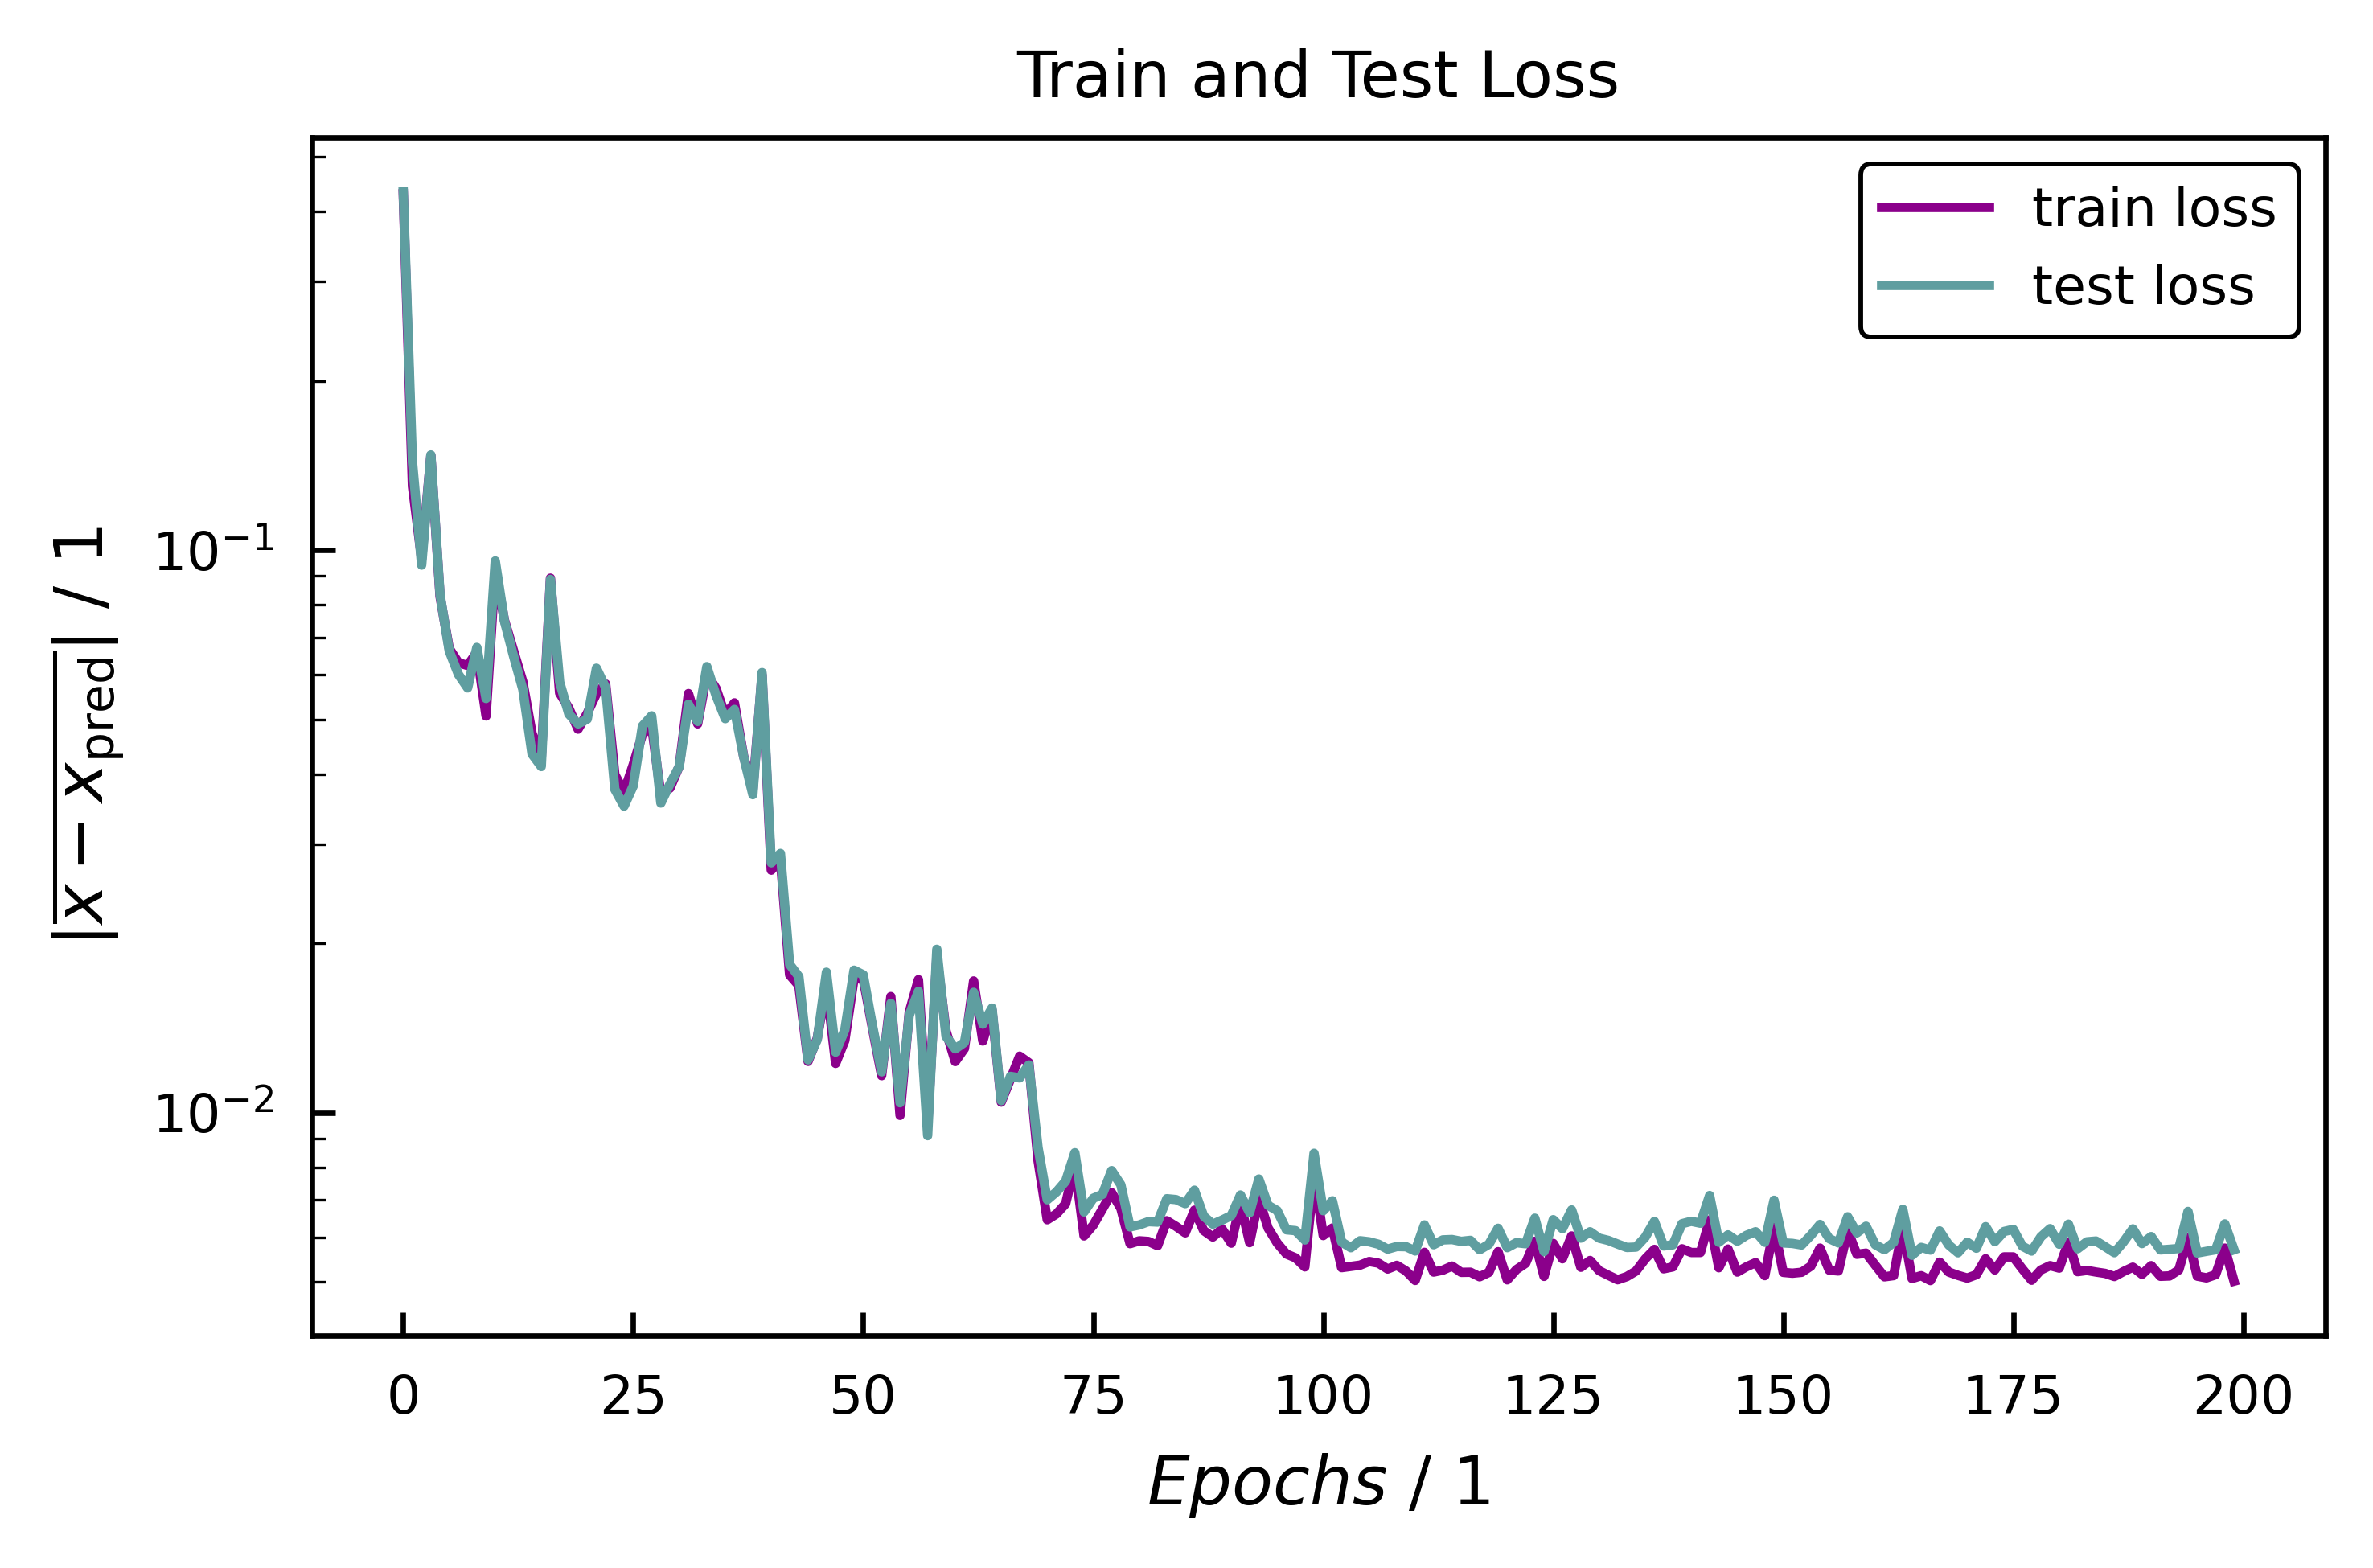

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\overline{x - x\mathregular{_{pred}}}$| / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9836352664234627 , R^2(NH3) = 0.9707205419027995
Test Dataset: R^2(H2) = 0.9851339086790823 , R^2(NH3) = 0.9712584495255038
Test Dataset: R^2(gemittelt)= 0.9781961791022931
Max Error Training: |x_H2 - x_H2,pred| = 0.11928848016413496 , |x_NH3 - x_NH3,pred| = 0.07702810350547568
Max Error Test: |x_H2 - x_H2,pred| = 0.11229098602818044 , |x_NH3 - x_NH3,pred| = 0.07374260330504896


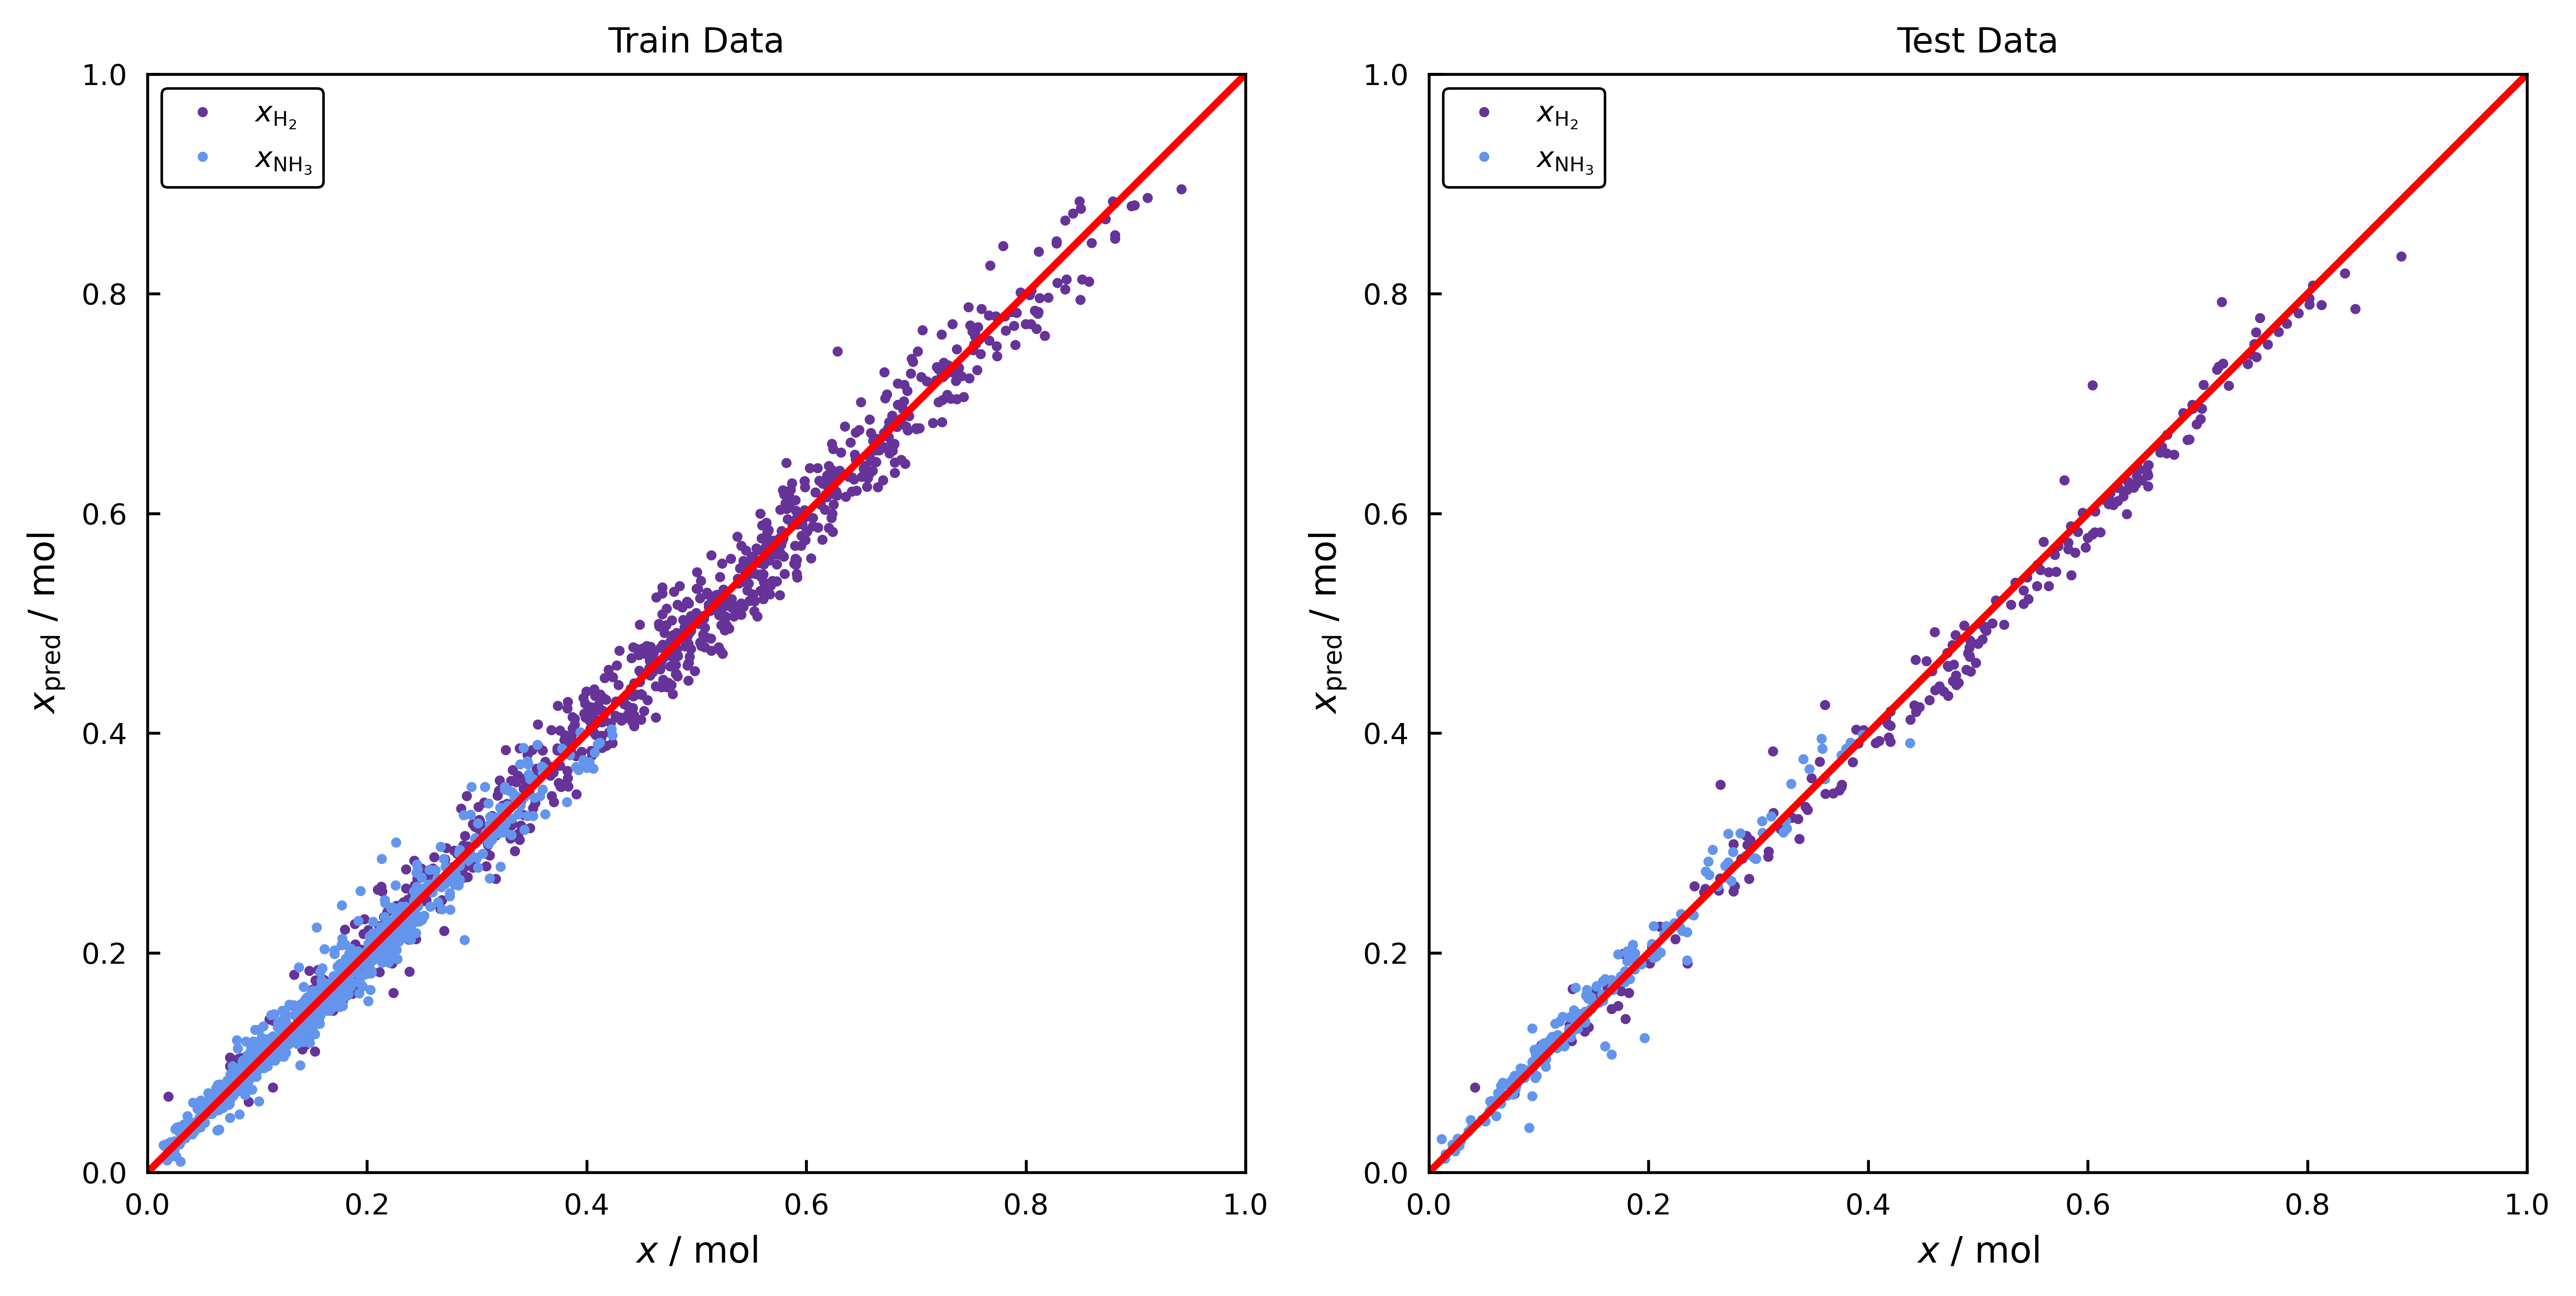

In [12]:
x_H2_real = []
x_H2_pred = []
x_NH3_real = []
x_NH3_pred = []
for (X,y) in train_dataloader:
    x_H2_real = np.append(x_H2_real, y[:,0].numpy())
    x_NH3_real = np.append(x_NH3_real, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred = np.append(x_H2_pred, help_x_H2)
    x_NH3_pred = np.append(x_NH3_pred, help_x_NH3)

x_H2_real_test = []
x_H2_pred_test = []
x_NH3_real_test = []
x_NH3_pred_test = []
for (X,y) in test_dataloader:
    x_H2_real_test = np.append(x_H2_real_test, y[:,0].numpy())
    x_NH3_real_test = np.append(x_NH3_real_test, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test = np.append(x_H2_pred_test, help_x_H2)
    x_NH3_pred_test = np.append(x_NH3_pred_test, help_x_NH3)

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Test Dataset: R^2(gemittelt)=', (r2(x_H2_real_test,x_H2_pred_test)+r2(x_NH3_real_test,x_NH3_pred_test))/2)
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$x$ / mol', ylabel = '$x\mathregular{_{pred}}$ / mol')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

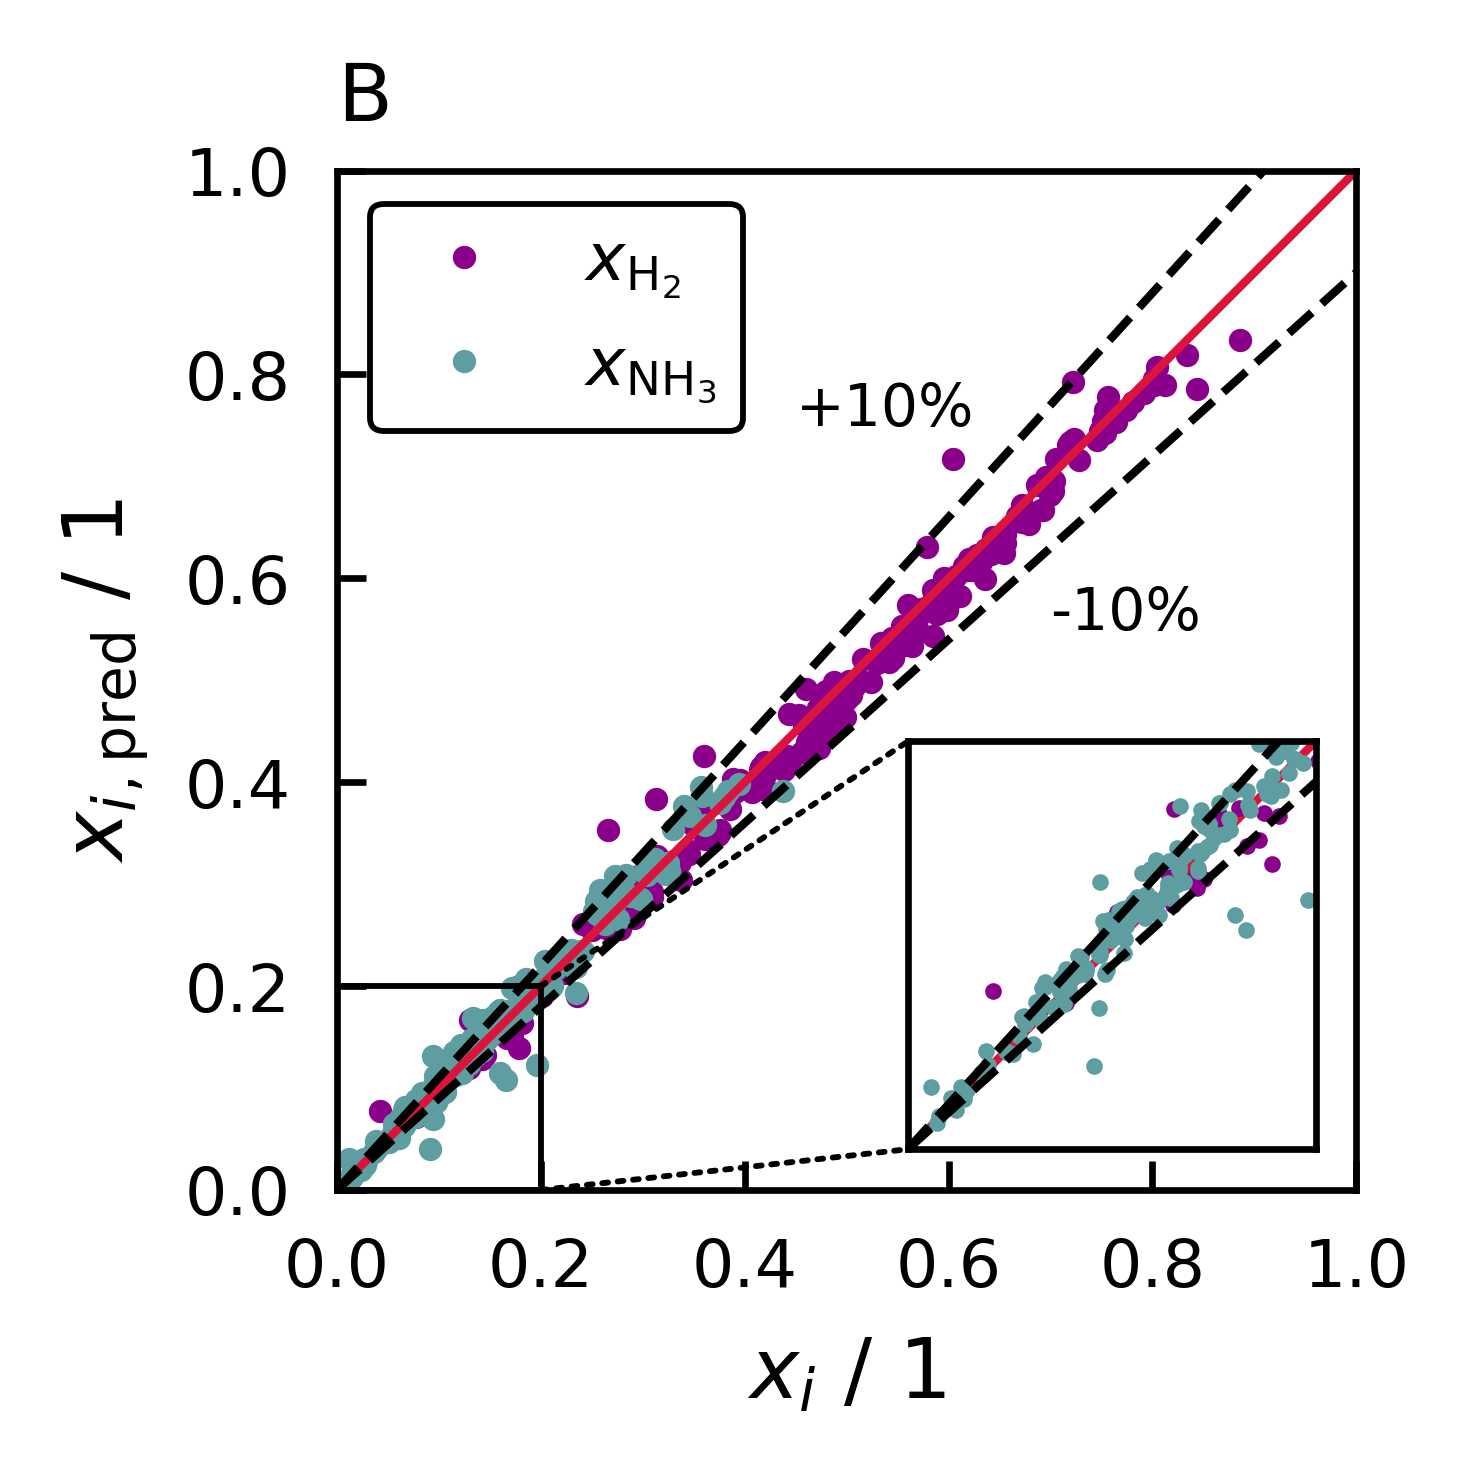

In [13]:
fig,ax = plt.subplots(figsize =(6.5*cm,6.5*cm))

# Reset the limits
#ax= plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

ax.plot(x_H2_real_test, x_H2_pred_test, '.', label = '$x\mathregular{_{H_2}}$')
ax.plot(x_NH3_real_test, x_NH3_pred_test, '.', label = '$x\mathregular{_{NH_3}}$')
ax.plot([0, 1], [0, 1], "-",color='crimson',lw=1 ,transform=ax.transAxes)
ax.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1) # Error line
ax.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1) # Error line
ax.text(0.45, 0.75, '+10%', fontsize=7)
ax.text(0.7, 0.55, '-10%', fontsize=7)


ax.set(xlabel = '$x_i$ / 1', ylabel = '$x_i\mathregular{_{,pred}}$ / 1')
ax.tick_params(direction = 'in') #, length = 20, width = 3)
ax.set_title('B',loc='left')
ax.legend()

x1,x2,y1,y2 = 0, 0.2, 0, 0.2 # subregion of origanal image
axin1 = ax.inset_axes([0.56, 0.04, 0.4, 0.4], xlim=(x1,x2), ylim=(y1,y2), xticks=[], yticks=[], xticklabels=[], yticklabels=[])

axin1.plot(x_H2_real_test, x_H2_pred_test, '.', markersize = 4)
axin1.plot(x_NH3_real_test, x_NH3_pred_test, '.', markersize = 4)
axin1.plot([0, 1], [0, 1], "-", color = 'crimson',lw=1,zorder=1 )
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--", lw=1)
axin1.plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--", lw=1)

rect = (x1, y1, x2 - x1, y2 - y1)
box1= ax.indicate_inset(rect, edgecolor="black", alpha=1,lw=0.7)

cp1 = ConnectionPatch(xyA=(0.2, 0.0), xyB=(0, 0), axesA=ax, axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)
cp2 = ConnectionPatch(xyA=(0.2, 0.2), xyB=(0, 1), axesA=ax, axesB=axin1,
                      coordsA="data", coordsB="axes fraction", lw=0.7, ls=":", zorder=100)

ax.add_patch(cp1)
ax.add_patch(cp2)


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

In [14]:
#fig.savefig(Path.cwd() / 'plots/ann/TKA_SRA_PA_011_parity_batchnorm.png', bbox_inches = 'tight')

#### Plot Fehler vs Epoch

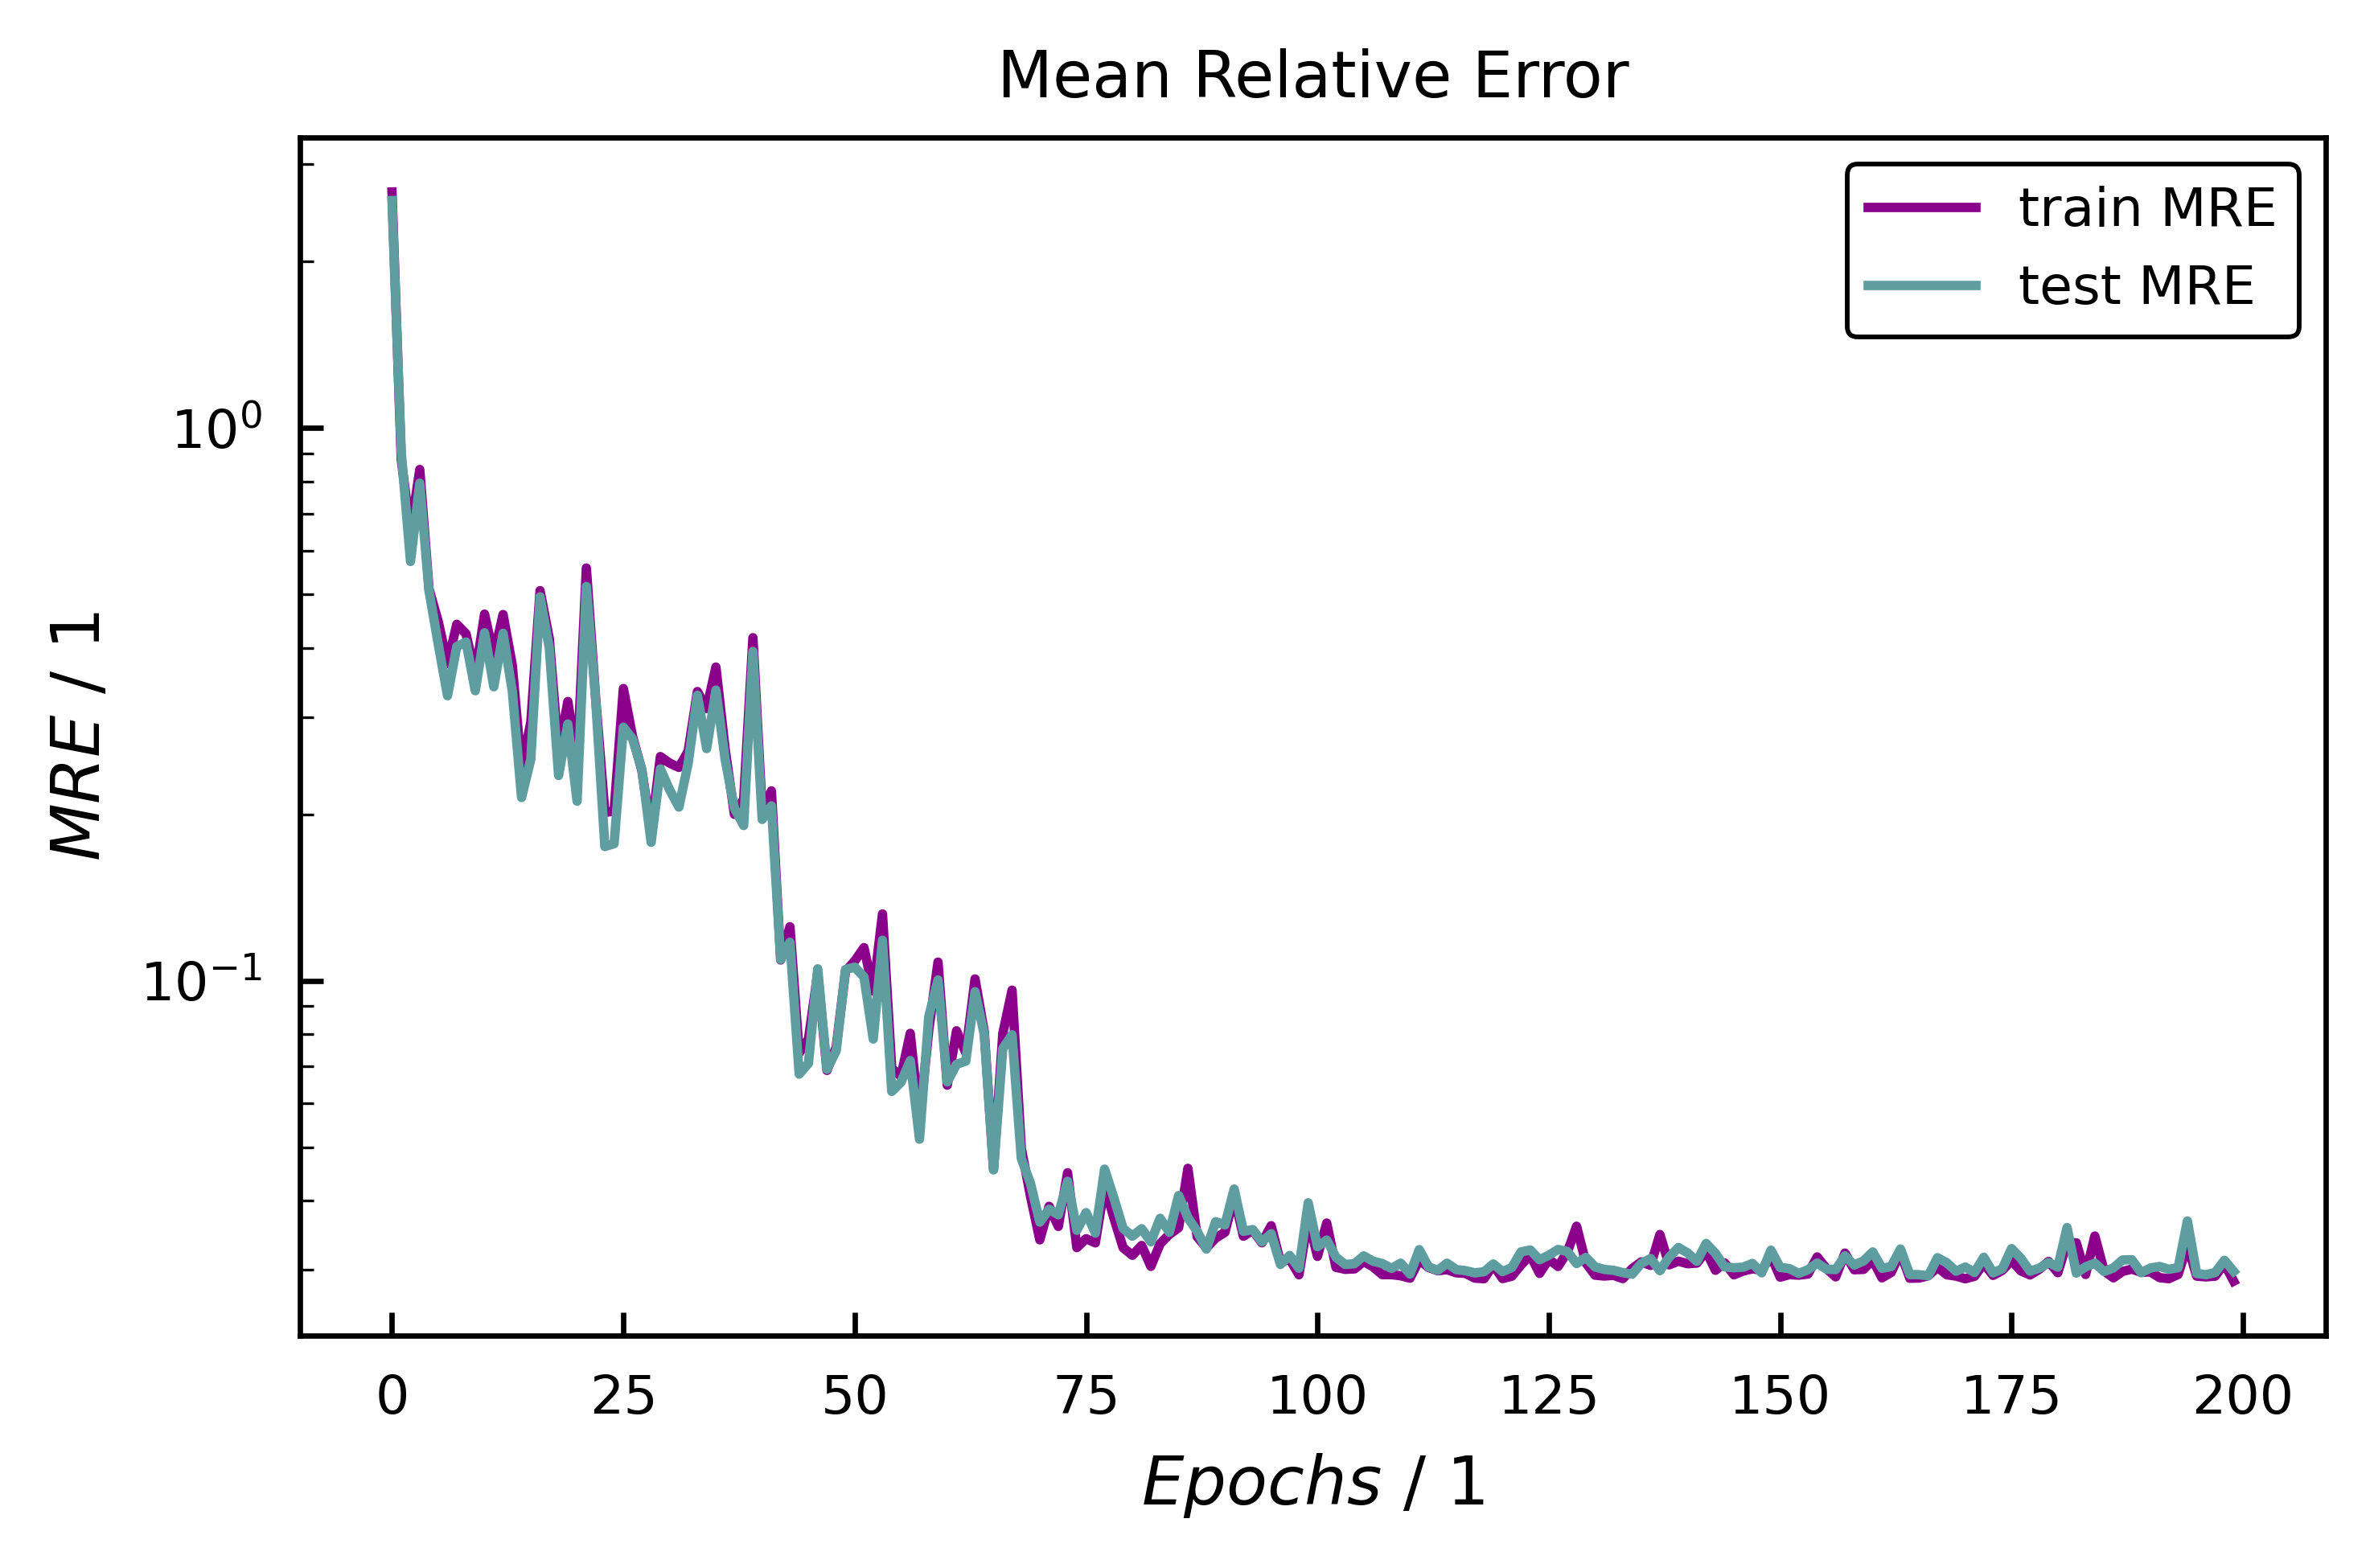

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_MRE, label='train MRE')
ax.semilogy(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

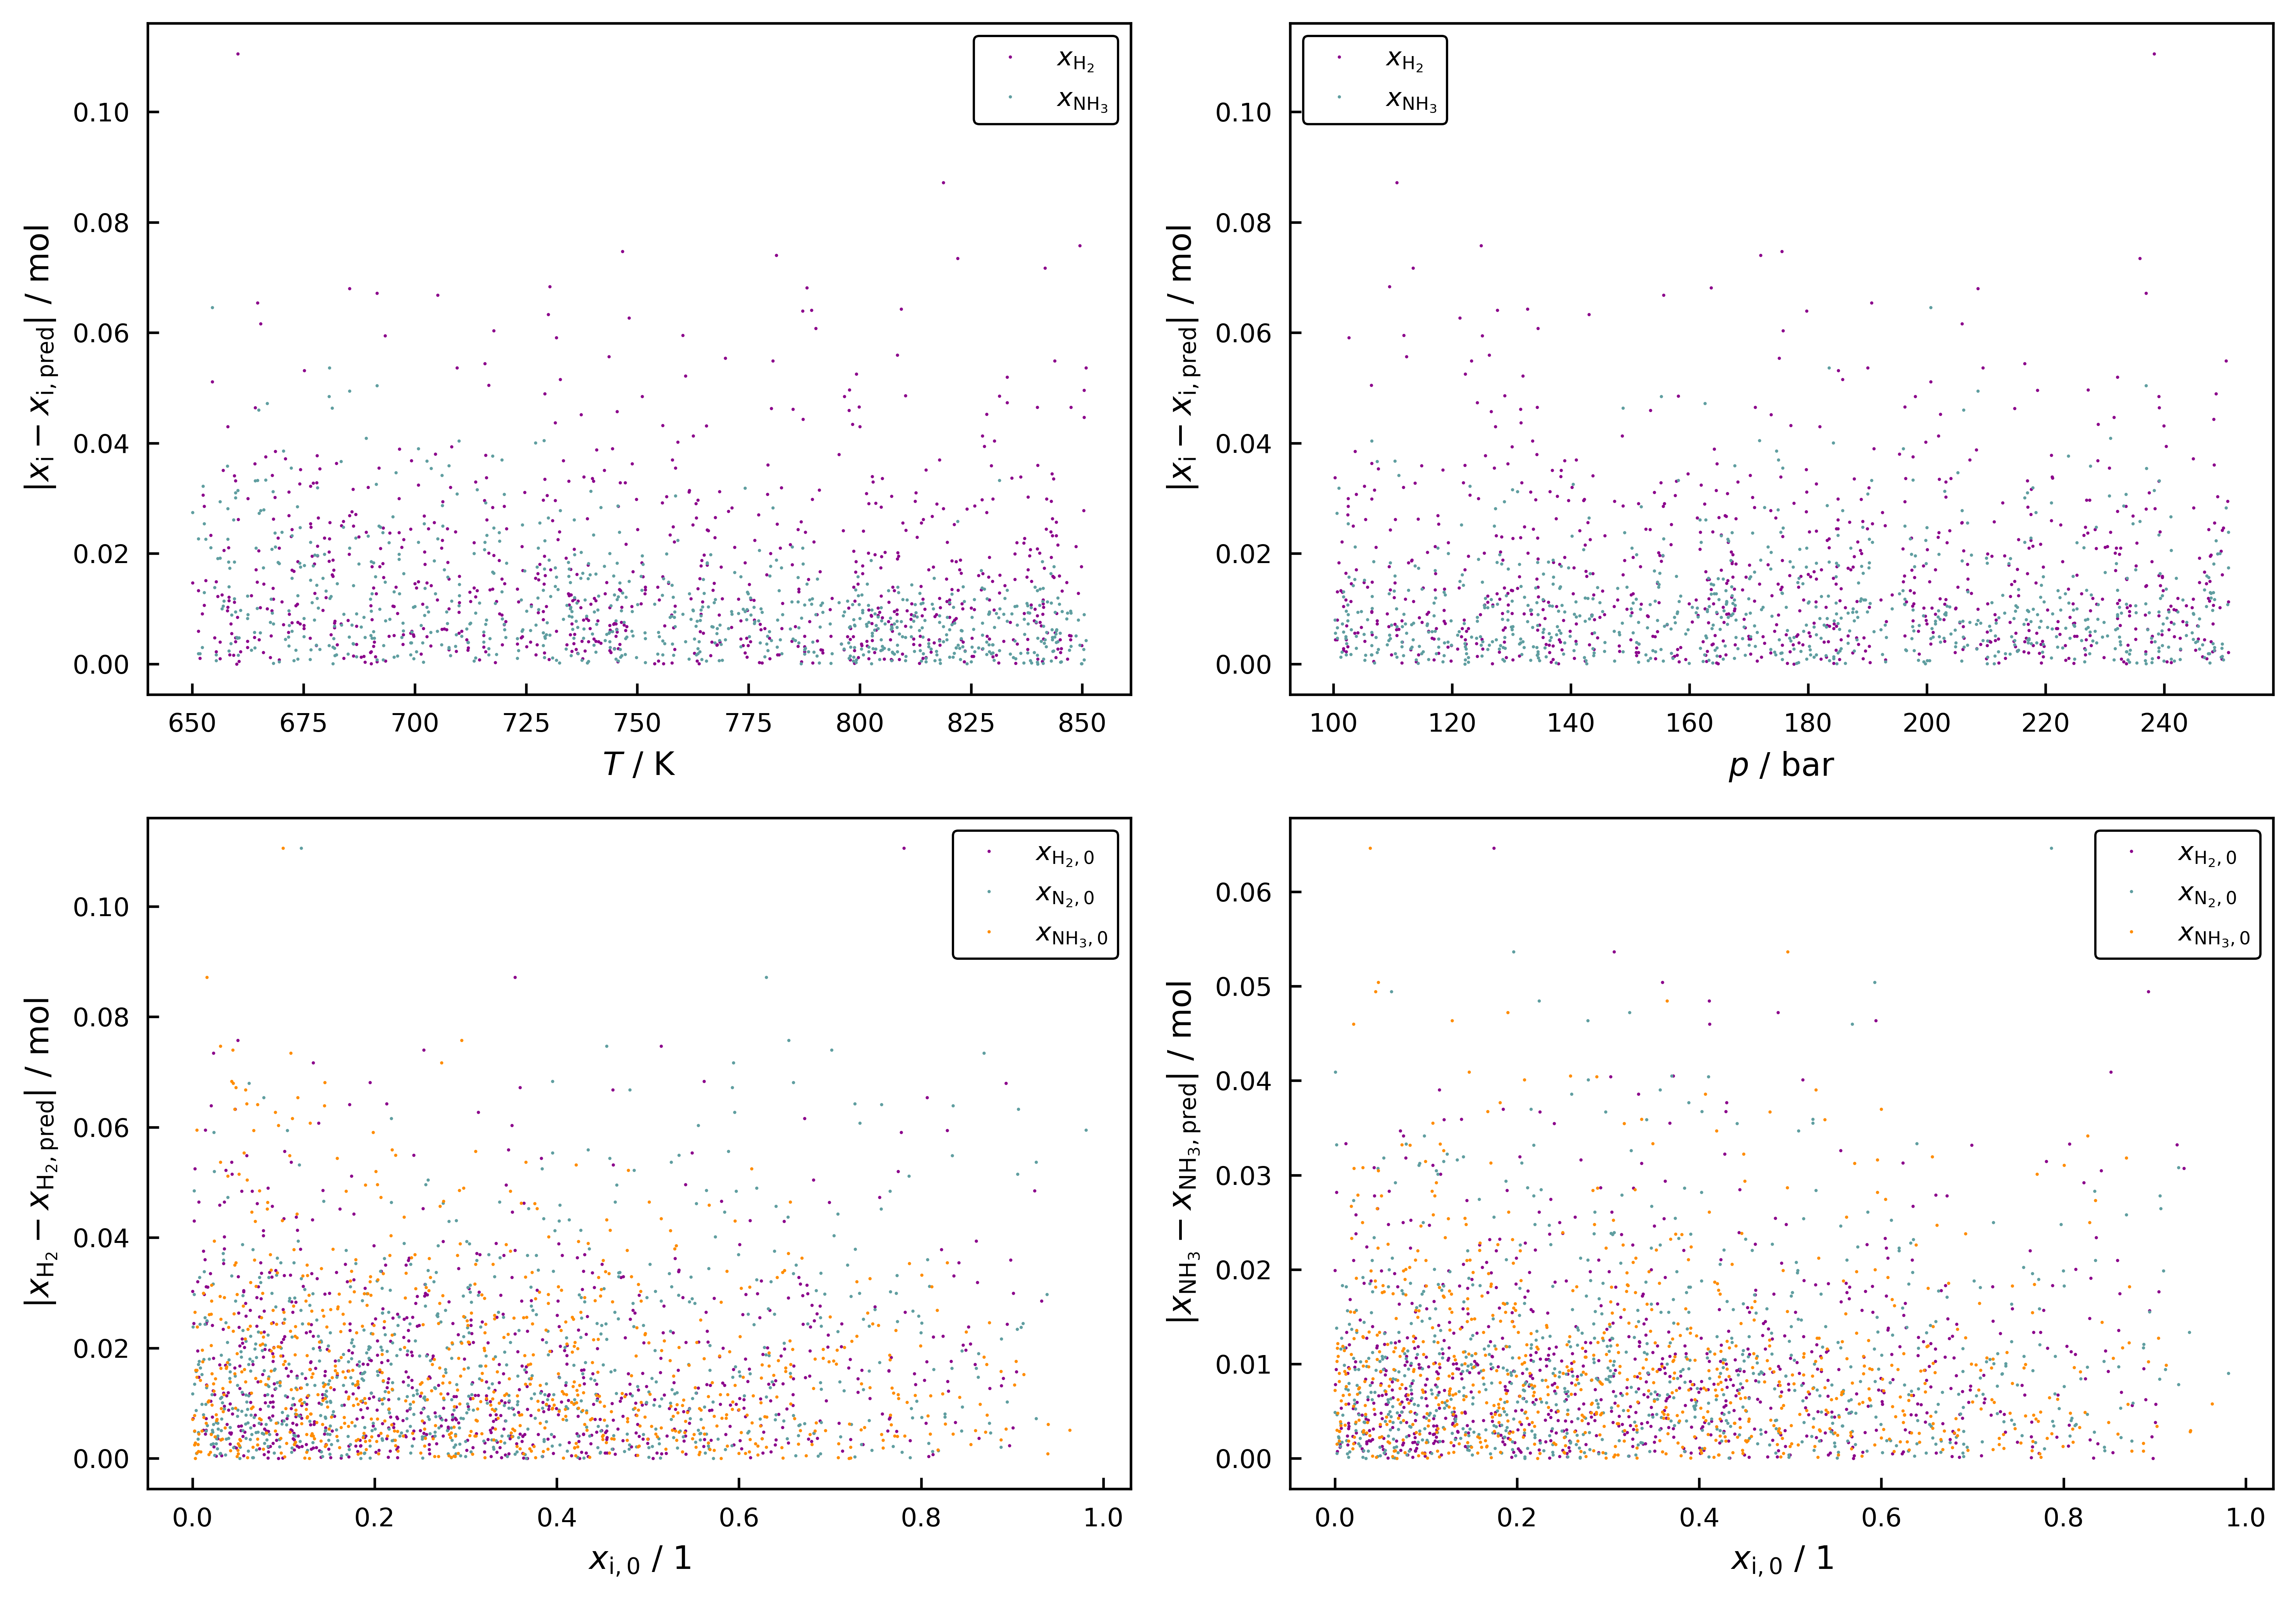

In [16]:
mistake_H2 = []
mistake_NH3 = []
param_T = []
param_p = []
param_x_H2_0 = []
param_x_N2_0 = []
param_x_NH3_0 = []
for X,y in train_dataloader:
    help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
    mistake_H2 = np.append(mistake_H2, help_mistake_H2)
    mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3)
    param_T = np.append(param_T, X[:,0])
    param_p = np.append(param_p, X[:,1])
    param_x_H2_0 = np.append(param_x_H2_0, X[:,2])
    param_x_N2_0 = np.append(param_x_N2_0, X[:,3])
    param_x_NH3_0 = np.append(param_x_NH3_0, X[:,4])

# train_parameters, train_xi = next(iter(train_dataloader))
# y = abs(train_xi - net(train_parameters).detach().numpy())
# #[T, p ,x_H2, x_N2, x_NH3]
# x = [train_parameters[:,0], train_parameters[:,1], train_parameters[:,2], train_parameters[:,3], train_parameters[:,4]]

# print(param_T[0])
# print(param_T)
# print(mistake)

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].plot(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].plot(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].plot(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].plot(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].plot(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].plot(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].plot(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].legend()

ax[1,1].plot(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].plot(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].plot(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].legend()

plt.tight_layout()
plt.show()

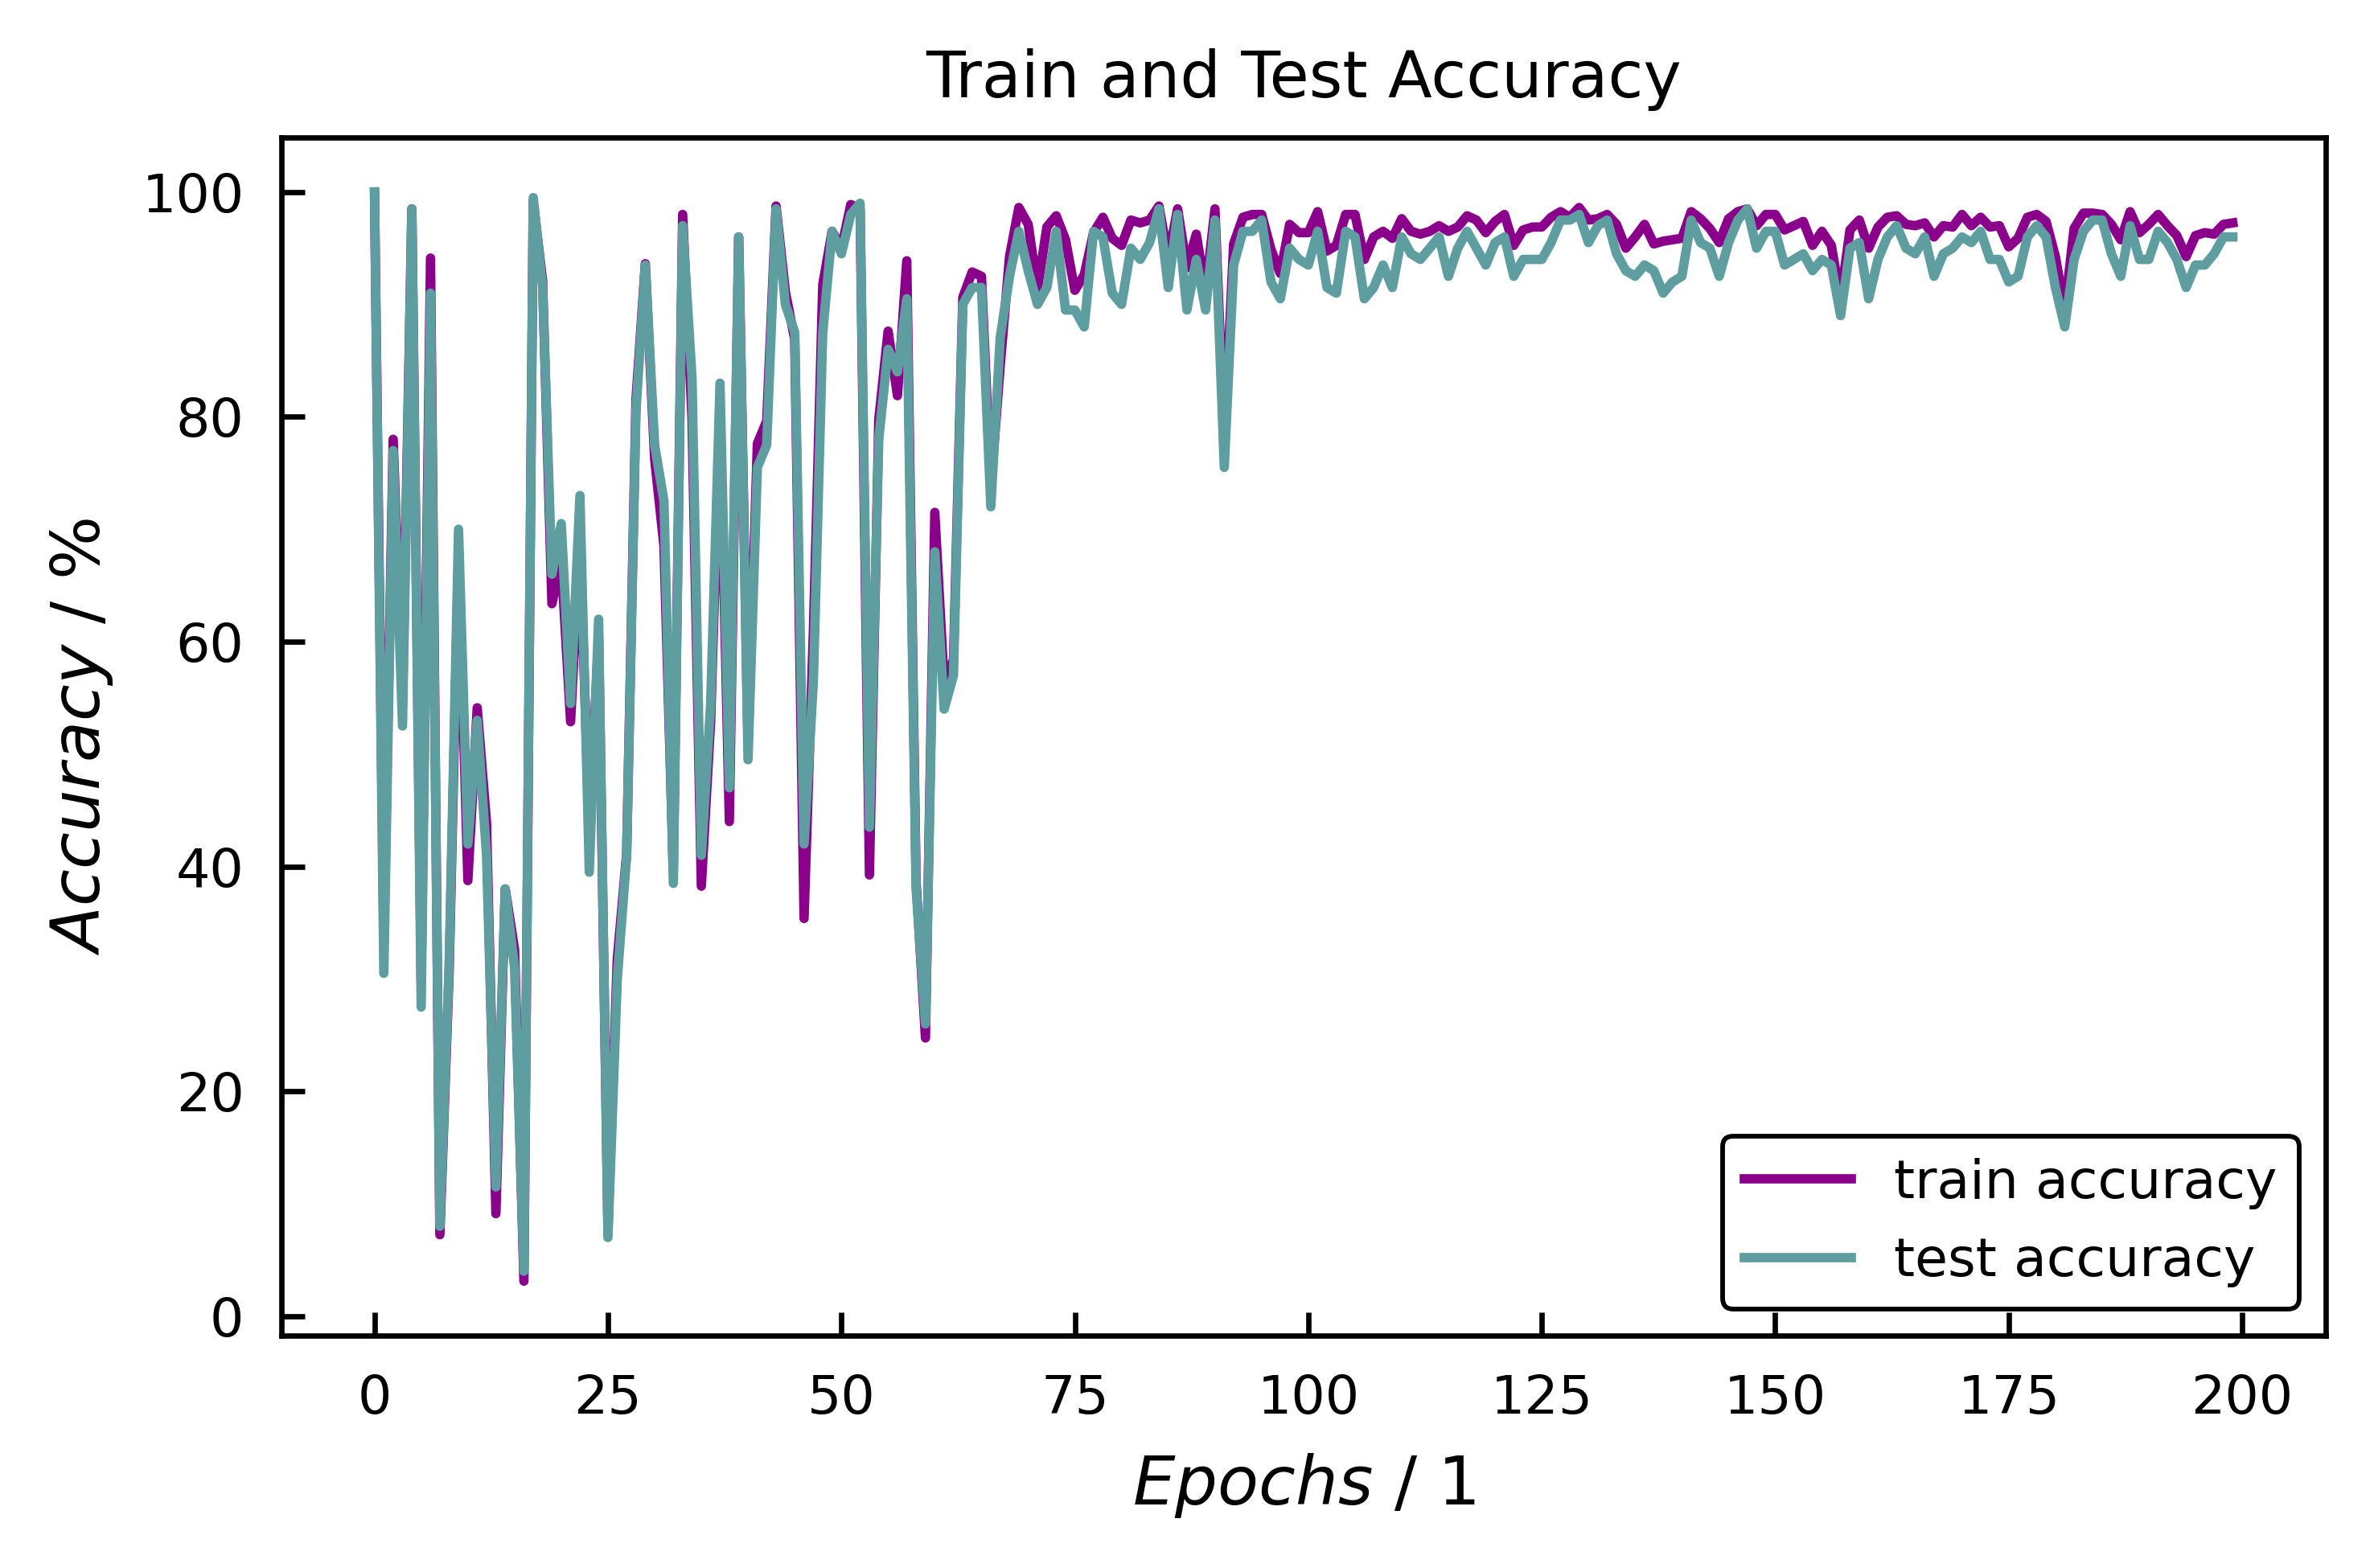

In [17]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [18]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[6.6535e+02, 2.0598e+02, 6.7199e-01, 2.1840e-01, 1.0961e-01],
        [6.8394e+02, 1.8917e+02, 5.8775e-02, 7.9730e-01, 1.4392e-01],
        [7.3533e+02, 1.6300e+02, 1.7138e-01, 2.4136e-01, 5.8726e-01],
        [8.1667e+02, 1.7842e+02, 4.5495e-01, 3.5790e-01, 1.8715e-01],
        [7.9858e+02, 2.4172e+02, 7.7293e-01, 2.1310e-03, 2.2493e-01],
        [7.3018e+02, 1.3702e+02, 5.1499e-01, 2.8084e-01, 2.0418e-01],
        [6.7416e+02, 1.8140e+02, 1.3678e-01, 1.1938e-01, 7.4384e-01],
        [7.4409e+02, 1.3644e+02, 2.2541e-01, 5.2203e-02, 7.2239e-01],
        [7.8719e+02, 1.7975e+02, 2.0347e-02, 8.3484e-01, 1.4481e-01],
        [7.4979e+02, 1.4228e+02, 1.4520e-01, 6.9401e-01, 1.6079e-01],
        [7.3900e+02, 1.6226e+02, 5.5325e-02, 1.7066e-01, 7.7401e-01],
        [8.1789e+02, 2.0727e+02, 4.3056e-01, 3.2537e-01, 2.4407e-01],
        [6.8585e+02, 1.7971e+02, 6.8875e-01, 2.5560e-01, 5.5648e-02],
        [8.0712e+02, 1.3770e+02, 5.6118e-02, 6.8454e-01, 2.5934e-01],
        [7.6390e+02,

#### Einblick in Netzwerk

In [19]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.8858, 0.8327, 0.8839, 0.9683, 0.8905], requires_grad=True),
 Parameter containing:
 tensor([-0.1343,  0.2047,  0.0709, -0.0817,  0.1205], requires_grad=True),
 Parameter containing:
 tensor([[-2.0464e-01,  2.3985e-01, -1.9881e-01,  1.2349e-01, -3.4282e-01],
         [-2.5717e-01,  2.5520e-01, -3.8695e-01, -5.8810e-02, -2.2205e-01],
         [ 6.3144e-02,  1.1962e-01, -2.7146e-01, -7.8480e-02, -1.6608e-01],
         [-2.6943e-01,  1.8906e-01,  3.2217e-01,  5.7863e-02,  4.0136e-01],
         [ 2.0362e-01,  1.4996e-02,  1.0258e-01,  3.2207e-01, -2.5871e-01],
         [ 3.8247e-01,  1.0128e-02,  5.4961e-02,  1.3405e-01, -2.1900e-02],
         [-1.6723e-01, -1.1760e-01, -4.2872e-01,  1.6037e-01,  1.5616e-01],
         [ 1.9331e-01, -1.0456e-01,  3.2152e-02, -1.9528e-01,  2.5662e-01],
         [-7.6836e-02,  2.3111e-01, -4.8223e-02,  2.8254e-01,  1.7298e-01],
         [-2.5739e-01, -1.2243e-01, -7.4162e-03, -3.6602e-02,  3.5302e-01],
         [ 3.2711e-01,  

In [20]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.6899, 0.1451, 0.3431, 0.5017, 0.5216],
        [0.4752, 0.4119, 0.4462, 0.8073, 0.7811]])
tensor([[ 0.3890, -0.1523],
        [ 0.4010,  0.2546]], grad_fn=<AddmmBackward0>)


In [21]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [22]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[6.6399e+02, 1.3534e+02, 5.7595e-02, 7.1950e-02, 8.7046e-01],
        [8.1789e+02, 2.0727e+02, 4.3056e-01, 3.2537e-01, 2.4407e-01],
        [7.7739e+02, 2.4122e+02, 1.4122e-01, 4.2275e-01, 4.3603e-01],
        [7.0717e+02, 2.4080e+02, 4.8858e-01, 8.0811e-02, 4.3061e-01],
        [6.9736e+02, 2.0905e+02, 6.7613e-01, 2.5236e-01, 7.1509e-02],
        [7.2329e+02, 1.9658e+02, 2.8682e-01, 1.4710e-01, 5.6608e-01],
        [6.6244e+02, 2.1470e+02, 5.4115e-01, 2.2755e-01, 2.3130e-01],
        [6.5535e+02, 2.0046e+02, 1.0475e-01, 6.0092e-01, 2.9433e-01],
        [7.2009e+02, 1.5623e+02, 4.4179e-01, 5.5805e-01, 1.5841e-04],
        [6.5005e+02, 2.1839e+02, 2.3686e-01, 1.5852e-01, 6.0462e-01],
        [6.5169e+02, 2.1324e+02, 4.3231e-01, 5.6299e-01, 4.7046e-03],
        [6.7658e+02, 1.0520e+02, 6.2442e-01, 2.0244e-01, 1.7314e-01],
        [7.2602e+02, 2.1077e+02, 3.9702e-01, 2.5228e-01, 3.5070e-01],
        [8.2349e+02, 1.5828e+02, 8.0834e-01, 1.4293e-01, 4.8721e-02],
        [7.2902e+02,

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()